# Load Dependencies

In [3]:
import pandas as pd
import numpy as np
import glob
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import Parameter
from rdkit import Chem
from torch.utils.data import Dataset
from script_baseline.Baseline_MG import Get_Baseline_MG_feat
from script_baseline.GCN import GCN1
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt

# Load Data

In [3]:
data_file = '../data1/data1.csv'
mol_dir = '../Data/data1/xtb_sdf/'
tmp_df = pd.read_csv(data_file)
labels_ori = tmp_df['Output'].to_list()
labels_ori=np.array(labels_ori)
label_std = (np.array(labels_ori)-np.min(labels_ori))/(np.max(labels_ori)-np.min(labels_ori))

In [4]:
def sort_func(x): return eval(x.split('/')[-1].split('.')[0].split('_')[-1])
lig_files = sorted(glob.glob(mol_dir+'lig_*.sdf'),key=sort_func)
add_files = sorted(glob.glob(mol_dir+'add_*.sdf'),key=sort_func)
base_files = sorted(glob.glob(mol_dir+'base_*.sdf'),key=sort_func)
ar_ha_files = sorted(glob.glob(mol_dir+'ar_ha_*.sdf'),key=sort_func)

sdf_file=lig_files+add_files+base_files+ar_ha_files
with open(mol_dir+'smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()
smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

# Generate Baseline MG

In [5]:
lig_Graph_name_dict=Get_Baseline_MG_feat(lig_files)

../Data/data1/xtb_sdf/lig_0.sdf
../Data/data1/xtb_sdf/lig_1.sdf
../Data/data1/xtb_sdf/lig_2.sdf
../Data/data1/xtb_sdf/lig_3.sdf


In [6]:
ar_ha_Graph_name_dict=Get_Baseline_MG_feat(ar_ha_files)

/PyScripts/PyTorch.dir/LSW/SEMG_MIGNN/SEMG_MIGNN1/baseline/../script/utils.py:111: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos(Xv_xy[0:3].dot(


../Data/data1/xtb_sdf/ar_ha_0.sdf
../Data/data1/xtb_sdf/ar_ha_1.sdf
../Data/data1/xtb_sdf/ar_ha_2.sdf
../Data/data1/xtb_sdf/ar_ha_3.sdf
../Data/data1/xtb_sdf/ar_ha_4.sdf
../Data/data1/xtb_sdf/ar_ha_5.sdf
../Data/data1/xtb_sdf/ar_ha_6.sdf
../Data/data1/xtb_sdf/ar_ha_7.sdf
../Data/data1/xtb_sdf/ar_ha_8.sdf
../Data/data1/xtb_sdf/ar_ha_9.sdf
../Data/data1/xtb_sdf/ar_ha_10.sdf
../Data/data1/xtb_sdf/ar_ha_11.sdf
../Data/data1/xtb_sdf/ar_ha_12.sdf
../Data/data1/xtb_sdf/ar_ha_13.sdf
../Data/data1/xtb_sdf/ar_ha_14.sdf


In [7]:
base_Graph_name_dict=Get_Baseline_MG_feat(base_files)

../Data/data1/xtb_sdf/base_0.sdf
../Data/data1/xtb_sdf/base_1.sdf
../Data/data1/xtb_sdf/base_2.sdf


In [8]:
add_Graph_name_dict=Get_Baseline_MG_feat(add_files)

/PyScripts/PyTorch.dir/LSW/SEMG_MIGNN/SEMG_MIGNN1/baseline/../script/utils.py:111: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos(Xv_xy[0:3].dot(


../Data/data1/xtb_sdf/add_0.sdf
../Data/data1/xtb_sdf/add_1.sdf
../Data/data1/xtb_sdf/add_2.sdf
../Data/data1/xtb_sdf/add_3.sdf
../Data/data1/xtb_sdf/add_4.sdf
../Data/data1/xtb_sdf/add_5.sdf
../Data/data1/xtb_sdf/add_6.sdf
../Data/data1/xtb_sdf/add_7.sdf
../Data/data1/xtb_sdf/add_8.sdf
../Data/data1/xtb_sdf/add_9.sdf
../Data/data1/xtb_sdf/add_10.sdf
../Data/data1/xtb_sdf/add_11.sdf
../Data/data1/xtb_sdf/add_12.sdf
../Data/data1/xtb_sdf/add_13.sdf
../Data/data1/xtb_sdf/add_14.sdf
../Data/data1/xtb_sdf/add_15.sdf
../Data/data1/xtb_sdf/add_16.sdf
../Data/data1/xtb_sdf/add_17.sdf
../Data/data1/xtb_sdf/add_18.sdf
../Data/data1/xtb_sdf/add_19.sdf
../Data/data1/xtb_sdf/add_20.sdf
../Data/data1/xtb_sdf/add_21.sdf


# Load Graph Dataset

In [9]:
class Graph_DataSet(Dataset):

    def __init__(self, root,csv_dir,sdf_dir, train=True, transform = None, target_transform=None):
        super(Graph_DataSet, self).__init__()
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        if self.train :
            file_annotation = root + csv_dir
            sdf_folder = root + sdf_dir
        else:
            file_annotation = root + csv_dir
            sdf_folder = root + sdf_dir
        df = pd.read_csv(file_annotation)
 
        target = np.array(df['Output'].to_list())
        self.target_min = target.min()
        self.target_range = target.max() - target.min()
        
        target_std = (target - target.min())/(target.max()-target.min())
        
        lig_smi = df['Ligand'].to_list()
        add_smi = df['Additive'].to_list()
        base_smi = df['Base'].to_list()
        ar_ha_smi = df['Aryl halide'].to_list()
        
        lig_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in lig_smi]
        add_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in add_smi]
        base_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in base_smi]
        ar_ha_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in ar_ha_smi]
        
        self.lig_file_names = lig_file_names
        self.add_file_names = add_file_names
        self.base_file_names = base_file_names
        self.ar_ha_file_names = ar_ha_file_names
        
        self.target_std = target_std
        self.sdf_folder = sdf_folder
            
    def __getitem__(self, index):
        lig_name = self.lig_file_names[index]
        add_name = self.add_file_names[index]
        base_name = self.base_file_names[index]
        ar_ha_name = self.ar_ha_file_names[index]
        label = self.target_std[index]

        graph_1 = lig_Graph_name_dict[lig_name]
        graph_2 = add_Graph_name_dict[add_name]
        graph_3 = base_Graph_name_dict[base_name]
        graph_4 = ar_ha_Graph_name_dict[ar_ha_name]
        return [graph_1,graph_1.ndata['feat'],graph_2,graph_2.ndata['feat'],graph_3,graph_3.ndata['feat'],graph_4,graph_4.ndata['feat']], label

    def __len__(self):
        return len(self.target_std)

# Train Model

In [10]:
loss = 'mse'
batch_size = 64
shuffle = np.array(list(range(3955)))
np.random.shuffle(shuffle)
train_index = shuffle[:2769]
val_index = shuffle[2769:]
dataset = Graph_DataSet('../Data/data1', '/data1.csv' ,'/xtb_sdf/')
train_data=[]
for i in train_index:
    tem_data=dataset[i]
    train_data.append(tem_data)
    
val_data=[]
for i in val_index:
    tem_data=dataset[i]
    val_data.append(tem_data) 

In [ ]:
#opt: conv 3; multi_graph_opt='mean'; output_opt='mean'
model_opt = GCN1(15,256,1,multi_graph_opt='mean',output_opt='mean',layer=3)
optimizer = optim.Adam(model_opt.parameters())
loss_func = torch.nn.L1Loss()
all_test=[]
all_pred=[]
for epoch in range(50):
    get_output=[]
    all_loss = []
    model_opt.train()
    for i, data in enumerate(train_data):
        inputs, labels = data
        outputs = model_opt(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],
                        inputs[6],inputs[7],)
        get_output.append(outputs)

        labels = torch.tensor(labels) 
        
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        all_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
    print(epoch,'Train MAE',np.mean(all_loss))
    model_opt.eval()
    test_get_output=[]
    test_all_labels = []
    all_loss = []
    for data in val_data:
        inputs, labels = data
        outputs = model_opt(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],
                        inputs[6],inputs[7],)
        test_get_output.append(outputs)
        labels = torch.tensor(labels) 
        test_all_labels.append(labels)
        loss = loss_func(outputs, labels)
        all_loss.append(loss.detach().numpy())
    all_test.append(test_all_labels)
    all_pred.append(test_get_output)
    print(epoch,'Test MAE',np.mean(all_loss))   

0 Train MAE 0.23544725107366596
0 Test MAE 0.22930071536472452
1 Train MAE 0.20987394888644778
1 Test MAE 0.20089998531423142
2 Train MAE 0.18102578845651393
2 Test MAE 0.1857870584587927
3 Train MAE 0.17337909276592892
3 Test MAE 0.17823399030354917
4 Train MAE 0.16733447962423945
4 Test MAE 0.17334483652883528
5 Train MAE 0.16479960743332164
5 Test MAE 0.17856678389368305
6 Train MAE 0.16359704405537587
6 Test MAE 0.17068775319539206
7 Train MAE 0.16279786400669485
7 Test MAE 0.17616720983302347
8 Train MAE 0.16161360680316
8 Test MAE 0.17855175688764882
9 Train MAE 0.16046741438864462
9 Test MAE 0.18046997011253493
10 Train MAE 0.1596138307971852
10 Test MAE 0.17834332641415135
11 Train MAE 0.15895624600005848
11 Test MAE 0.17570671098239504
12 Train MAE 0.15852664424117338
12 Test MAE 0.17170592799779552
13 Train MAE 0.1577975952895356
13 Test MAE 0.16899549739738595
14 Train MAE 0.15716258217125564
14 Test MAE 0.1640109378254155
15 Train MAE 0.15679609509643558
15 Test MAE 0.16530

In [ ]:
test_all_labels_=[]
for i in test_all_labels:
    test_all_labels_.append(i.tolist())
    
test_get_output_=[]
for i in test_get_output:
    test_get_output_.append(i.tolist())
y_val=np.array(test_all_labels_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
y_pred=np.array(test_get_output_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()

# Results

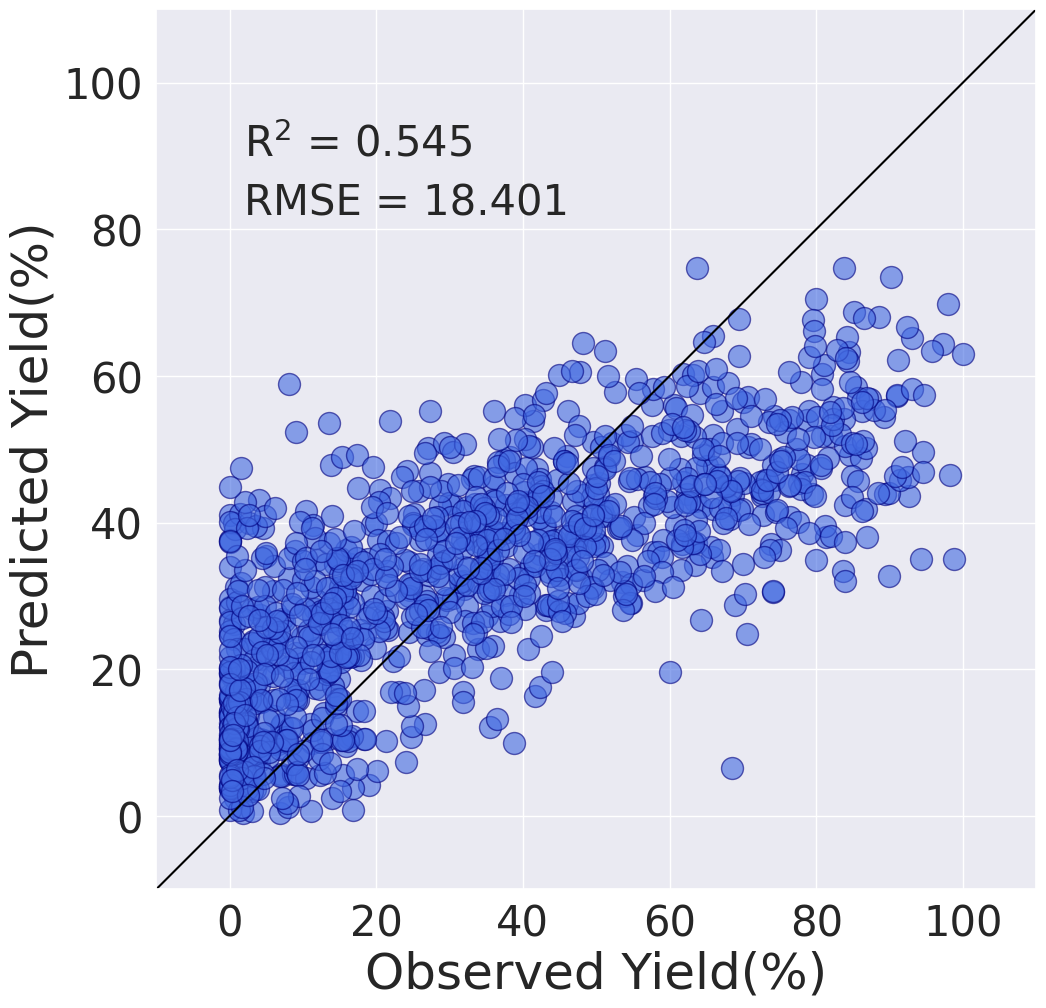

In [4]:
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',  
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-10,110],[-10,110],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=36)
plt.ylabel("Predicted Yield(%)",fontsize=36)

plt.tick_params(labelsize=30)
plt.text(2,82,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(2,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

In [5]:
np.save( '../result/data1_Baseline_MG_GCN_y_val.npy',y_val)
np.save( '../result/data1_Baseline_MG_GCN_y_pred.npy',y_pred)